# Polar Codes in 5G
Polar codes in 5G are used for forward error correction for small to medium payload sizes which is typically the case for broadcast and control channels. The broadcast channel and control channel are used to carry the *master information block* (MIB) and *downlink control information* (DCI) repsectively. This tutorial covers the following content:


## Table of content:
* [Symbol Mapping Configurations](#Symbol-Mapping-Configurations)
* [Simulation Parameters](#Polar-Coder-Configurations)
* [Simulation for BER vs SNR](#Simulation:-AWGN-Channel)
* [Performance Evaluation](#Performance-Evaluations)


## Import libraries
### Python Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
from   mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from   mpl_toolkits.axes_grid1.inset_locator import mark_inset

import numpy as np

### 5G Toolkit libraries

In [2]:
from toolkit5G.SymbolMapping import Demapper
from toolkit5G.SymbolMapping import Mapper
from toolkit5G.ChannelCoder  import PolarEncoder5G
from toolkit5G.ChannelCoder  import PolarDecoder5G

In [3]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:70% !important; }</style>"))

## Symbol Mapping Configurations
Symbol mapping/Demapping is performed for:

- **QPSK** constellation defined by ``constellation_type`` which encodes
- 1 bit per contellation symbol defined by ``num_bits_per_symbol``.
- The demapper generates log likelihood ratios configured by ``hard_out`` 
- using a Log-Map (**"app"**) decoder defined using ``demapping_method``.

In [4]:
constellation_type  = "qam"
num_bits_per_symbol = 2
hard_out            = False
demapping_method    = "app"

mapper  = Mapper(constellation_type, num_bits_per_symbol)
demapper= Demapper(demapping_method, constellation_type,  num_bits_per_symbol, hard_out = hard_out)

## Polar Coder Configurations
The simulations parameters are:

- ``K`` defines block-length.
- ``SNRdB`` defines Signal to noise ratio (SNR) in dB.
- ``purpose`` defines the physical channel for which the Polar coder is used.
- ``verbose`` displays the details of the simulation if configured to True.
- ``decoderType`` defines the type of Polar Decoder used.

In [5]:
K       = 56      # Number of bits to encode
E       = 864     # Rate matching bits
purpose = "PDCCH" # The channel for which the Polar Encoder
verbose = False   
decoderType ='SC'

## Simulation: AWGN Channel
This subsection performs the simulation which involve following steps:

* Bits generation of length ``k``
* Polar Encoding
* BPSK Symbol Mapping of encoded bits
* Passing through the AWGN Channel
    * Adding noise to BPSK symbols with a given SNR
* Symbol De-mapping using **Log Map** Demapper defined by  ``"app"``.
    * Generates Log likelihood values as ``hard_out`` is set to ``False``.
* Polar Decoding
* BER computation

The flow of the implementation can be understood using folowing diagram:
![PolarCodes](Polar.png)

The bit error rate (BER) is computed for every combination of K $= \{20, 50,  80, 110, 140\}$ and SNR $= \{-10, -8, -6, -4, -2, 0\}$ dB and averaged over $500000$ batches (monteCarloIterations).

In [6]:
K          = np.int32(np.linspace(20,140,5))
SNRdB      = np.linspace(-10,0,5)
SNR        = 10**(SNRdB/10)
numBatches = 1000
BER        = np.zeros((K.size, SNR.size))

kIndex   = 0
snrIndex = 0
for k in K:
    #######################################################
    ################ Generate UCI Payload #################
    #######################################################
    bits    = np.float32(np.random.randint(2, size = (numBatches, k)))

    #######################################################
    ################### Polar Encoder #####################
    #######################################################
    encoder = PolarEncoder5G(k, E, purpose,verbose)
    encBits = encoder(bits)

    #######################################################
    ################### Rate Matching #####################
    #######################################################
    encoder = PolarEncoder5G(k, E, purpose,verbose)


    #######################################################
    ################### Symbol Mapping ####################
    #######################################################
    symbols  = mapper(encBits)

    decoder  = PolarDecoder5G(K = k, E = E, purpose = purpose, dec_type = decoderType)
    snrIndex = 0
    for snr in SNR:

        #######################################################
        ################ Add Noise at Receiver ################
        #######################################################
        symbs    = symbols + np.sqrt(0.5/snr)*(np.random.standard_normal(size=symbols.shape)+1j*np.random.standard_normal(size=symbols.shape)).astype(np.complex64)

        #######################################################
        ################## Symbol Demapping ###################
        #######################################################
        llrEst   = demapper([symbs,  np.float32(1/snr)])

        #######################################################
        ################ Reed Muller Decoder ##################
        #######################################################
        rxBits   = decoder(llrEst)

        #######################################################
        ############## Key Performance Metrics ################
        #######################################################
        BER[kIndex, snrIndex] = np.mean(np.abs(rxBits-bits))

        print("For K="+str(k)+", At SNR(dB): "+str(SNRdB[snrIndex])+" | Bit Error Rate: "+str(BER[kIndex, snrIndex]))

        snrIndex = snrIndex + 1
    kIndex = kIndex + 1

For K=20, At SNR(dB): -10.0 | Bit Error Rate: 0.2743000090122223
For K=20, At SNR(dB): -7.5 | Bit Error Rate: 0.08980000019073486
For K=20, At SNR(dB): -5.0 | Bit Error Rate: 0.003100000089034438
For K=20, At SNR(dB): -2.5 | Bit Error Rate: 0.0
For K=20, At SNR(dB): 0.0 | Bit Error Rate: 0.0
For K=50, At SNR(dB): -10.0 | Bit Error Rate: 0.41582000255584717
For K=50, At SNR(dB): -7.5 | Bit Error Rate: 0.18559999763965607
For K=50, At SNR(dB): -5.0 | Bit Error Rate: 0.007199999876320362
For K=50, At SNR(dB): -2.5 | Bit Error Rate: 0.0
For K=50, At SNR(dB): 0.0 | Bit Error Rate: 0.0
For K=80, At SNR(dB): -10.0 | Bit Error Rate: 0.48739999532699585
For K=80, At SNR(dB): -7.5 | Bit Error Rate: 0.4479624927043915
For K=80, At SNR(dB): -5.0 | Bit Error Rate: 0.18539999425411224
For K=80, At SNR(dB): -2.5 | Bit Error Rate: 0.004937500227242708
For K=80, At SNR(dB): 0.0 | Bit Error Rate: 0.0
For K=110, At SNR(dB): -10.0 | Bit Error Rate: 0.49500909447669983
For K=110, At SNR(dB): -7.5 | Bit Err

## Performance Evaluations
The script plots SNR in dB vs BER performance for different code-block lengths $\text{K} \in \{20, 50, 80, 110, 140\}$. It can be observed that the Polar codes can provide the reliablilty of 

- $99.99990 \text{ or BER = } 10^{-4}$ for all the block-sizes supported in downlink even at low SNR value of 0 dB. 

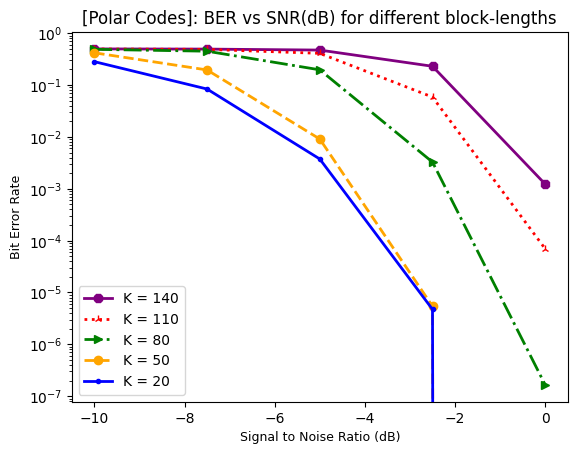

In [7]:
fig, ax = plt.subplots()

color_tuple     = ['blue', 'orange', 'green',   'red',    'purple', 'brown',       'pink',  'gray', 'olive', 'cyan', 'black']
markcolor_tuple = ['gold', 'navy',   'crimson', 'yellow', 'line',   'springgreen', 'black', 'aqua', 'royalblue', 'red', 'green']
linestyle_tuple = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted']
marker_tuple    = [".", "o", ">", "2", "8", "s", "p", "*", "P", "X", "D"]

kIndex = K.size-1
for k in np.flip(K):
    ax.semilogy(SNRdB, BER[kIndex], color=color_tuple[kIndex%len(color_tuple)], 
                linestyle=linestyle_tuple[kIndex%len(linestyle_tuple)], lw = 2,
                marker=marker_tuple[kIndex%len(marker_tuple)], markersize = 6, label="K = "+str(k))
    
    kIndex = kIndex - 1

ax.legend(loc="lower left")
ax.set_xlabel("Signal to Noise Ratio (dB)", fontsize = 9)
ax.set_ylabel("Bit Error Rate", fontsize = 9)
ax.set_title("[Polar Codes]: BER vs SNR(dB) for different block-lengths", fontsize = 12)
plt.rcParams.update({'font.size': 9})
plt.show()